In [31]:
# Core Library modules
import os  # Operating system interactions, such as reading and writing files.
import shutil  # High-level file operations like copying and moving files.
import random  # Random number generation for various tasks.
import textwrap  # Formatting text into paragraphs of a specified width.
import warnings  # Warning control context manager.
import zipfile  # Work with ZIP archives.
import platform  # Access to underlying platform’s identifying data.
import itertools  # Functions creating iterators for efficient looping.
from dataclasses import dataclass, field  # Class decorator for adding special methods to classes.

# PyTorch and Deep Learning Libaries
import torch  # Core PyTorch library for tensor computations.
import torch.nn as nn  # Neural network module for defining layers and architectures.
from torch.nn import functional as F  # Functional module for defining functions and loss functions.
import torch.optim as optim  # Optimizer module for training models (SGD, Adam, etc.).
from torch.utils.data import Dataset, DataLoader, Subset, random_split  # Data handling and batching
import torchvision  # PyTorch's computer vision library.
from torchvision import datasets, transforms  # Image datasets and transformations.
import torchvision.datasets as datasets  # Specific datasets for vision tasks.
import torchvision.transforms as transforms  # Transformations for image preprocessing.
from torchvision.utils import make_grid  # Grid for displaying images.
import torchvision.models as models  # Pretrained models for transfer learning.
from torchvision.datasets import MNIST, EuroSAT  # Standard datasets.
import torchvision.transforms.functional as TF  # Functional transformations.
from torchvision.models import ResNet18_Weights  # ResNet-18 model with pretrained weights.
from torchsummary import summary  # Model summary.
import torchmetrics  # Model evaluation metrics.
from torchmetrics import MeanMetric, Accuracy  # Accuracy metrics.
from torchmetrics.classification import (
    MultilabelF1Score, MultilabelRecall, MultilabelPrecision, MultilabelAccuracy
)  # Classification metrics.
from torchviz import make_dot  # Model visualization.
from torchvision.ops import sigmoid_focal_loss  # Focal loss for class imbalance.
from torchcam.methods import GradCAM  # Grad-CAM for model interpretability.
from torchcam.utils import overlay_mask  # Overlay mask for visualizations.
import pytorch_lightning as pl  # Training management.
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, Callback  # Callbacks.
from pytorch_lightning.loggers import TensorBoardLogger  # Logger for TensorBoard.

# Geospatial Data Processing Libraries
import rasterio  # Reading and writing geospatial raster data.
from rasterio.warp import calculate_default_transform, reproject  # Reprojection and transformation.
from rasterio.enums import Resampling  # Resampling for raster resizing.
from rasterio.plot import show  # Visualization of raster data.

# Data Manipulation, Analysis and Visualization Libraries
import pandas as pd  # Data analysis and manipulation.
import numpy as np  # Array operations and computations.
from sklearn.metrics import confusion_matrix, accuracy_score  # Evaluation metrics.
import matplotlib.pyplot as plt  # Static and interactive plotting.
import seaborn as sns  # High-level interface for statistical graphics.

# Utility Libraries
from tqdm import tqdm  # Progress bar for loops.
from PIL import Image  # Image handling and manipulation.
import ast  # Parsing Python code.
import requests  # HTTP requests.
import zstandard as zstd  # Compression and decompression.
from collections import Counter  # Counting hashable objects.
import certifi  # Certificates for HTTPS.
import ssl  # Secure connections.
import urllib.request  # URL handling.
import kaggle  # Kaggle API for datasets.
from IPython.display import Image  # Display images in notebooks.
from pathlib import Path # File system path handling.
from typing import Dict, List, Tuple  # Type hints.
import sys  # System-specific parameters and functions.
import time # Time access and conversions.
import logging # Logging facility for Python.
import json # JSON encoder and decoder.
from torch.optim.lr_scheduler import ReduceLROnPlateau
from contextlib import redirect_stdout
import rasterio
from rasterio.plot import show
import numpy as np
import scipy.ndimage

# Custom Libraries

In [32]:
# Set seed for reproducibility
SEED = 42  
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.set_float32_matmul_precision('medium')

# Set environment variables
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "upb"


# Render plots
%matplotlib inline
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device} {'(GPU: ' + torch.cuda.get_device_name(0) + ')' if device.type == 'cuda' else ''}")

Device: cuda (GPU: NVIDIA GeForce RTX 3050)


In [33]:
def set_random_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def clean_and_parse_labels(label_string):
    cleaned_labels = label_string.replace(" '", ", '").replace("[", "[").replace("]", "]")
    return ast.literal_eval(cleaned_labels)

# Function to normalize class weights
def normalize_class_weights(class_weights):
    total_weight = sum(class_weights)
    return [weight / total_weight for weight in class_weights]

# Function to calculate class weights based on the label counts of each category
def calculate_class_weights(metadata_csv):
    metadata_csv['labels'] = metadata_csv['labels'].apply(clean_and_parse_labels)

    class_labels = set()
    for labels in metadata_csv['labels']:
        class_labels.update(labels)

    label_counts = metadata_csv['labels'].explode().value_counts()
    total_counts = label_counts.sum()
    
    # Calculate class weights
    class_weights = {label: total_counts / count for label, count in label_counts.items()}
    class_weights_array = np.array([class_weights[label] for label in class_labels])
    
    # Normalize class weights
    normalized_class_weights = normalize_class_weights(class_weights_array)
    
    return class_weights, normalized_class_weights

# Function used to calculate the class labels within the metadata
def calculate_class_labels(metadata_csv):
    metadata_csv['labels'] = metadata_csv['labels'].apply(clean_and_parse_labels)

    class_labels = set()
    for labels in metadata_csv['labels']:
        class_labels.update(labels)

    return class_labels

def decode_target(
    target: list,
    text_labels: bool = False,
    threshold: float = 0.4,
    cls_labels: dict = None,
):
    result = []
    for i, x in enumerate(target):
        if x >= threshold:
            if text_labels:
                result.append(cls_labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return " ".join(result)


def get_band_indices(band_names, all_band_names):
    return [all_band_names.index(band) for band in band_names]


def get_labels_for_image(image_path, model, transform, patch_to_labels):
    # Load and preprocess the image
    with rasterio.open(image_path) as src:
        bands = [2, 3, 4]  # Bands to combine for display
        image = np.stack([src.read(band) for band in bands], axis=-1)
        image = transform(image).unsqueeze(0).to(model.device)  # Add batch dimension and move to device

    # Get the predicted labels
    model.eval()
    with torch.no_grad():
        preds = model(image).sigmoid() > 0.5  # Apply sigmoid and threshold at 0.5
        preds = preds.cpu().numpy().astype(int).flatten()

    # Get the true labels
    patch_id = os.path.basename(image_path).split('.')[0]
    true_labels = patch_to_labels[patch_id]

    return preds, true_labels, image

def display_image(image_path):
    with rasterio.open(image_path) as src:
        bands = [2, 3, 4]  # Bands to combine for display
        image = np.stack([src.read(band) for band in bands], axis=-1)
        plt.imshow(image)
        plt.title("Image with Bands 2, 3, and 4")
        plt.show()

def display_image_and_labels(image_path, model, transform, patch_to_labels):
    # Display the image
    display_image(image_path)

    # Get predicted and true labels
    preds, true_labels, _ = get_labels_for_image(image_path, model, transform, patch_to_labels)
    print(f"Predicted Labels: {preds}")
    print(f"True Labels: {true_labels}")

def extract_number(string):
    number_str = string.split('%')[0]
    try:
        number = float(number_str)
        if number.is_integer():
            return int(number)
        return number
    except ValueError:
        raise ValueError(f"Cannot extract a number from the string: {string}")
    

# Define the hook function
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

In [34]:
class BandNormalisation:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        for i in range(image.shape[0]):
            image[i] = (image[i] - self.mean[i]) / self.std[i]
        return image
    
class BandUnnormalisation:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        for i in range(image.shape[0]):
            image[i] = (image[i] * self.std[i]) + self.mean[i]
        return image
    
class ToTensor:
    def __call__(self, image):
        return torch.tensor(image, dtype=torch.float32)

In [35]:
# Description: Configuration file for the project
# Helper functions
def denormalize(tensors, *, mean, std):
    for c in range(12):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

def encode_label(label: list, num_classes=19):
    target = torch.zeros(num_classes)
    for l in label:
        if l in DatasetConfig.class_labels_dict:
            target[DatasetConfig.class_labels_dict[l]] = 1.0
    return target

@dataclass
class DatasetConfig:
    metadata_path = r"C:\\Users\\isaac\\Desktop\BigEarthTests\\50%_BigEarthNet\\metadata_50_percent.csv"
    dataset_paths = {
        "0.5": r"C:\Users\isaac\Desktop\BigEarthTests\0.5%_BigEarthNet\CombinedImages",
        "1": r"C:\Users\isaac\Desktop\BigEarthTests\1%_BigEarthNet\CombinedImages",
        "5": r"C:\Users\isaac\Desktop\BigEarthTests\5%_BigEarthNet\CombinedImages",
        "10": r"C:\Users\isaac\Desktop\BigEarthTests\10%_BigEarthNet\CombinedImages",
        "50": r"C:\Users\isaac\Desktop\BigEarthTests\50%_BigEarthNet\CombinedImages",
        "100": r"C:\Users\isaac\Desktop\BigEarthTests\100%_BigEarthNet\CombinedImages"
    }
    metadata_paths = {
        "0.5": r"C:\Users\isaac\Desktop\BigEarthTests\0.5%_BigEarthNet\metadata_0.5_percent.csv",
        "1": r"C:\Users\isaac\Desktop\BigEarthTests\1%_BigEarthNet\metadata_1_percent.csv",
        "5": r"C:\Users\isaac\Desktop\BigEarthTests\5%_BigEarthNet\metadata_5_percent.csv",
        "10": r"C:\Users\isaac\Desktop\BigEarthTests\10%_BigEarthNet\metadata_10_percent.csv",
        "50": r"C:\Users\isaac\Desktop\BigEarthTests\50%_BigEarthNet\metadata_50_percent.csv",
        "100": r"C:\Users\isaac\Desktop\BigEarthTests\100%_BigEarthNet\metadata_100_percent.csv"
    }
    unwanted_metadata_file: str = r'C:\Users\isaac\Downloads\metadata_for_patches_with_snow_cloud_or_shadow.parquet'
    unwanted_metadata_csv = pd.read_parquet(unwanted_metadata_file)

    class_labels = calculate_class_labels(pd.read_csv(metadata_path))
    class_labels = class_labels
    class_labels_dict = {label: idx for idx, label in enumerate(class_labels)}
    reversed_class_labels_dict = {idx: label for label, idx in class_labels_dict.items()}

    num_classes: int = 19
    band_channels: int = 12
    valid_pct: float = 0.1
    img_size: int = 120

    rgb_bands = ["B04", "B03", "B02"]
    rgb_nir_bands = ["B04", "B03", "B02", "B08"]
    rgb_swir_bands = ["B04", "B03", "B02", "B11", "B12"]
    rgb_nir_swir_bands = ["B04", "B03", "B02", "B08", "B11", "B12"]
    all_imp_bands = [ "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
    all_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]
    
    band_stats = {
        "mean": {
            "B01": 359.93681858037576,
            "B02": 437.7795146920668,
            "B03": 626.9061237185847,
            "B04": 605.0589129818594,
            "B05": 971.6512098450492,
            "B06": 1821.9817358749056,
            "B07": 2108.096240315571,
            "B08": 2256.3215618504346,
            "B8A": 2310.6351913265307,
            "B09": 2311.6085833217353,
            "B11": 1608.6865167942176,
            "B12": 1017.1259618291762
        },
        "std": {
            "B01": 583.5085769396974,
            "B02": 648.4384481402268,
            "B03": 639.2669907766995,
            "B04": 717.5748664544205,
            "B05": 761.8971822905785,
            "B06": 1090.758232889144,
            "B07": 1256.5524552734478,
            "B08": 1349.2050493390414,
            "B8A": 1287.1124261320342,
            "B09": 1297.654379610044,
            "B11": 1057.3350765979644,
            "B12": 802.1790763840752
        }
    }

@dataclass
class ModelConfig:
    num_epochs: int = 10
    batch_size: int = 32
    num_workers: int = os.cpu_count() // 2
    learning_rate: float = 0.0001
    momentum: float = 0.9
    weight_decay: float = 1e-4
    lr_step_size: int = 7
    lr_factor: float = 0.1
    patience: int = 5
    lr_patience: int = 5
    dropout: float = 0.5

    model_names: list = field(default_factory=lambda: [
        'resnet18', 
        'resnet34', 
        'resnet50', 
        'resnet101', 
        'resnet152', 
        'densenet121', 
        'densenet169', 
        'densenet201', 
        'densenet161',
        'efficientnet-b0',
        'vgg16',
        'vgg19'
    ])

@dataclass
class ModuleConfig:
    reduction: int = 16
    ratio: int = 8
    kernel_size: int = 3
    dropout_rt: float = 0.1
    activation: type = nn.ReLU

@dataclass
class TransformsConfig:
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=(120, 120), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((120, 120))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((120, 120))
    ])

    normalisations = transforms.Compose([
        BandNormalisation(
            mean=[DatasetConfig.band_stats["mean"][band] for band in DatasetConfig.all_bands],
            std=[DatasetConfig.band_stats["std"][band] for band in DatasetConfig.all_bands]
        )
    ])


@dataclass
class UnormalisationConfig:
    unormalization = BandUnnormalisation(
        mean=[DatasetConfig.band_stats["mean"][band] for band in DatasetConfig.all_bands],
        std=[DatasetConfig.band_stats["std"][band] for band in DatasetConfig.all_bands]
    )


In [39]:
class BigEarthNetDatasetTIF(Dataset):
    def __init__(self, *, df, root_dir, transforms=None, normalisation=None, is_test=False, selected_bands=None, metadata_csv=None):
        self.df = df
        self.root_dir = root_dir
        self.transforms = transforms
        self.normalisation = normalisation
        self.is_test = is_test
        self.selected_bands = selected_bands if selected_bands is not None else DatasetConfig.rgb_bands
        self.metadata = metadata_csv

        self.image_paths = list(Path(root_dir).rglob("*.tif"))
        self.patch_to_labels = dict(zip(self.metadata['patch_id'], self.metadata['labels']))
        self.image_paths = list(Path(root_dir).rglob("*.tif"))

        self.selected_band_indices = get_band_indices(self.selected_bands, DatasetConfig.all_bands)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        with rasterio.open(image_path) as src:
            image = src.read()  
            image = image[self.selected_band_indices, :, :]
        

        image = torch.tensor(image, dtype=torch.float32)

        if self.transforms:
            image = self.transforms(image)

        if self.normalisation:
            image = self.normalisation(image)

        label = self.get_label(image_path)

        return image, label

    def get_label(self, img_path):
        img_path = Path(img_path) 
        patch_id = img_path.stem
        labels = self.patch_to_labels.get(patch_id, None)

        if labels is None:
            return torch.zeros(DatasetConfig.num_classes)  
    
        if isinstance(labels, str):
            cleaned_labels = labels.replace(" '", ", '").replace("[", "[").replace("]", "]")
            labels =  ast.literal_eval(cleaned_labels)
        
        encoded = encode_label(labels)
        return encoded

In [40]:
metadata_csv = pd.read_csv(DatasetConfig.metadata_paths['50'])
full_df = metadata_csv
dataset_dir = DatasetConfig.dataset_paths['50']
bands = DatasetConfig.all_bands
dataset = BigEarthNetDatasetTIF(df=full_df, root_dir=dataset_dir, transforms=None, normalisation=TransformsConfig.normalisations, selected_bands=bands, metadata_csv=metadata_csv)

In [41]:
print("Length of dataset: " + str(len(dataset)))
print("Number of classes: " + str(DatasetConfig.num_classes))
image, label = dataset[0]
print("Image shape: " + str(image.shape))
print("Label shape: " + str(label.shape))

print(image)
print(label)

Length of dataset: 239988
Number of classes: 19
Image shape: torch.Size([12, 120, 120])
Label shape: torch.Size([19])
tensor([[[-0.6168, -0.6168, -0.6168,  ..., -0.6168, -0.6168, -0.6168],
         [-0.6168, -0.6168, -0.2621,  ..., -0.6168, -0.6168, -0.6168],
         [-0.2682, -0.2621, -0.2621,  ..., -0.6168, -0.6168, -0.6168],
         ...,
         [-0.6168, -0.6168, -0.6168,  ..., -0.6168, -0.6168, -0.6168],
         [-0.6168, -0.6168, -0.6168,  ..., -0.6168, -0.6168, -0.6168],
         [-0.6168, -0.6168, -0.6168,  ..., -0.6168, -0.6168, -0.6168]],

        [[-0.6751, -0.6751, -0.6751,  ..., -0.6751, -0.6751, -0.6751],
         [-0.6751, -0.6751, -0.3803,  ..., -0.6751, -0.6751, -0.6751],
         [-0.3658, -0.3711, -0.3822,  ..., -0.6751, -0.6751, -0.6751],
         ...,
         [-0.6751, -0.6751, -0.6751,  ..., -0.6751, -0.6751, -0.6751],
         [-0.6751, -0.6751, -0.6751,  ..., -0.6751, -0.6751, -0.6751],
         [-0.6751, -0.6751, -0.6751,  ..., -0.6751, -0.6751, -0.6751]],

In [28]:
# Data module for BigEarthNet dataset
class BigEarthNetTIFDataModule(pl.LightningDataModule):
    def __init__(self, bands=None, dataset_dir=None, metadata_csv=None):
        super().__init__()
        self.bands = bands
        self.dataset_dir = dataset_dir
        self.metadata_csv = metadata_csv

    def setup(self, stage=None):
        train_df = self.metadata_csv[self.metadata_csv['split'] == 'train']
        val_df = self.metadata_csv[self.metadata_csv['split'] == 'validation']
        test_df = self.metadata_csv[self.metadata_csv['split'] == 'test']

        self.train_dataset = BigEarthNetDatasetTIF(df=train_df, root_dir=self.dataset_dir, transforms=TransformsConfig.train_transforms, selected_bands=self.bands, metadata_csv=self.metadata_csv)
        self.val_dataset = BigEarthNetDatasetTIF(df=val_df, root_dir=self.dataset_dir, transforms=TransformsConfig.val_transforms, selected_bands=self.bands, metadata_csv=self.metadata_csv)
        self.test_dataset = BigEarthNetDatasetTIF(df=test_df, root_dir=self.dataset_dir, transforms=TransformsConfig.test_transforms, selected_bands=self.bands, metadata_csv=self.metadata_csv)
        
    def train_dataloader(self):
        dataloader = DataLoader(self.train_dataset, batch_size=ModelConfig.batch_size, num_workers=0, pin_memory=True, shuffle=True, persistent_workers=False)
        return dataloader

    def val_dataloader(self):
        dataloader = DataLoader(self.val_dataset, batch_size=ModelConfig.batch_size,  num_workers=0, pin_memory=True,  persistent_workers=False)
        return dataloader

    def test_dataloader(self):
        dataloader = DataLoader(self.test_dataset, batch_size=ModelConfig.batch_size,  num_workers=0, pin_memory=True,  persistent_workers=False)
        return dataloader

In [30]:
metadata_path = DatasetConfig.metadata_paths["0.5"]
metadata_csv = pd.read_csv(metadata_path)

dataset_dir = DatasetConfig.dataset_paths["0.5"]

class_weights, class_weights_array = calculate_class_weights(metadata_csv)
class_weights = class_weights_array

print(f"Class Weights: {class_weights}")

bands = DatasetConfig.all_bands

# Initialize the data module
data_module = BigEarthNetTIFDataModule(bands=bands, dataset_dir=dataset_dir, metadata_csv=metadata_csv)
data_module.setup(stage=None)

Class Weights: [0.008963789272922506, 0.0037858674577945562, 0.0031201706679670448, 0.01482081067284346, 0.0034503474582281072, 0.023930850260738067, 0.007976950086912689, 0.017989397782209995, 0.053233932212662226, 0.050162743815777865, 0.0055736382017530966, 0.004290234668454686, 0.3726375254886356, 0.3726375254886356, 0.00841439573684016, 0.0367389109636683, 0.0028918654971401875, 0.0037104732267716203, 0.005670571040044455]


In [12]:
print(DatasetConfig.reversed_class_labels_dict)
print(class_weights)

{0: 'Inland waters', 1: 'Broad-leaved forest', 2: 'Mixed forest', 3: 'Agro-forestry areas', 4: 'Coniferous forest', 5: 'Inland wetlands', 6: 'Urban fabric', 7: 'Permanent crops', 8: 'Industrial or commercial units', 9: 'Natural grassland and sparsely vegetated areas', 10: 'Complex cultivation patterns', 11: 'Land principally occupied by agriculture, with significant areas of natural vegetation', 12: 'Coastal wetlands', 13: 'Beaches, dunes, sands', 14: 'Moors, heathland and sclerophyllous vegetation', 15: 'Marine waters', 16: 'Arable land', 17: 'Transitional woodland, shrub', 18: 'Pastures'}
[ 23.93814433  10.11030479   8.33253589  39.57954545   9.21428571
  63.90825688  21.30275229  48.04137931 142.16326531 133.96153846
  14.88461538  11.45723684 995.14285714 995.14285714  22.47096774
  98.11267606   7.72283814   9.90896159  15.14347826]


In [49]:
test_dataloader = data_module.test_dataloader()

batch = next(iter(test_dataloader))
images, labels = batch
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

print(images)

Images shape: torch.Size([32, 12, 120, 120])
Labels shape: torch.Size([32, 19])
tensor([[[[-2.4667e-01, -2.4667e-01, -2.4667e-01,  ..., -2.3639e-01,
           -2.3639e-01, -2.3639e-01],
          [-2.4667e-01, -2.4667e-01, -2.4667e-01,  ..., -2.3639e-01,
           -2.3639e-01, -2.3639e-01],
          [-2.4667e-01, -2.4667e-01, -2.4667e-01,  ..., -2.3639e-01,
           -2.3639e-01, -2.3639e-01],
          ...,
          [-2.5867e-01, -2.5867e-01, -2.5867e-01,  ..., -2.0383e-01,
           -2.0383e-01, -2.0383e-01],
          [-2.5867e-01, -2.5867e-01, -2.5867e-01,  ..., -2.0383e-01,
           -2.0383e-01, -2.0383e-01],
          [-2.5867e-01, -2.5867e-01, -2.5867e-01,  ..., -2.0383e-01,
           -2.0383e-01, -2.0383e-01]],

         [[-3.9908e-01, -3.8366e-01, -4.0988e-01,  ..., -4.2376e-01,
           -4.0833e-01, -3.9908e-01],
          [-3.8983e-01, -4.3147e-01, -4.7002e-01,  ..., -4.1142e-01,
           -4.0217e-01, -4.0217e-01],
          [-3.9754e-01, -4.3764e-01, -4.3609e-0

In [50]:
for img_idx, (images, labels) in enumerate(test_dataloader):
    print(img_idx)
    print(images.min(), images.max())


0
tensor(-1.7944) tensor(26.6644)
1
tensor(-1.7649) tensor(6.5854)


KeyboardInterrupt: 

tensor([[0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
         0.],
        [0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0.],
        [0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

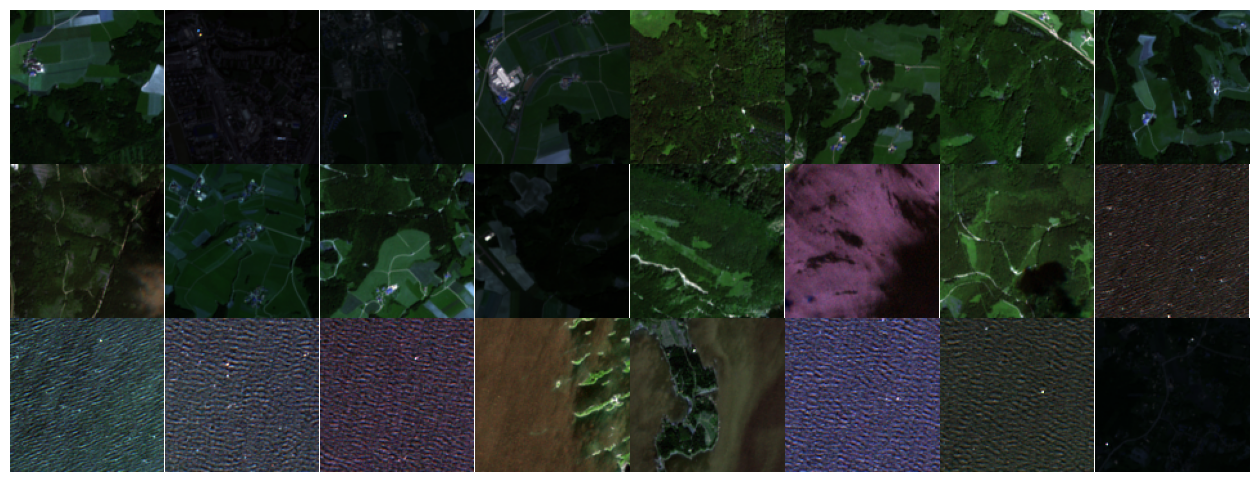

In [51]:
# Define the unnormalization transform using the BandUnnormalisation class
unnormalization_transform = BandUnnormalisation(
    mean=[DatasetConfig.band_stats["mean"][band] for band in DatasetConfig.all_bands],
    std=[DatasetConfig.band_stats["std"][band] for band in DatasetConfig.all_bands]
)

# Number of images per row in the grid
images_per_row = 8

# Initialize a list to store RGB images
rgb_images = []

# Iterate through the test dataloader
for img_idx, (images, labels) in enumerate(test_dataloader):
    for batch_idx in range(images.size(0)):
        selected_bands = images[batch_idx, [1, 2, 3], :, :]  # Shape: (3, H, W)
        unnormalized_bands = unnormalization_transform(selected_bands.clone())
        print(labels)
        band_array = unnormalized_bands.numpy()
        
        # Normalize values to range [0, 255] for display
        band_array = (band_array - band_array.min(axis=(1, 2), keepdims=True)) / (band_array.max(axis=(1, 2), keepdims=True) - band_array.min(axis=(1, 2), keepdims=True))
        band_array = (band_array * 255).astype(np.uint8)
        
        rgb_image = band_array.transpose(1, 2, 0)  # (H, W, 3)
        rgb_images.append(rgb_image)
        
        # Stop after collecting a few images for brevity
        if len(rgb_images) >= images_per_row * 3:
            break
    if len(rgb_images) >= images_per_row * 3:
        break

# Plot images in a tight grid
n_rows = len(rgb_images) // images_per_row + (len(rgb_images) % images_per_row != 0)
fig, axes = plt.subplots(n_rows, images_per_row, figsize=(images_per_row * 2, n_rows * 2))

for idx, ax in enumerate(axes.flat):
    if idx < len(rgb_images):
        ax.imshow(rgb_images[idx])
        ax.axis("off")
    else:
        ax.axis("off")  

plt.subplots_adjust(wspace=0, hspace=0)  
plt.show()


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class BigEarthNetResNet18ModelTIF(pl.LightningModule):
    def __init__(self, class_weights, num_classes, in_channels, model_weights):
        super(BigEarthNetResNet18ModelTIF, self).__init__()
        self.model = models.resnet18(weights=model_weights)

        original_conv1 = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            in_channels=in_channels,  
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=original_conv1.bias,
        )
        nn.init.kaiming_normal_(self.model.conv1.weight, mode='fan_out', nonlinearity='relu')

        # Modify the final layer to output 19 classes
        self.model.fc = nn.Linear(self.model.fc.in_features, DatasetConfig.num_classes)

        self.sigmoid = nn.Sigmoid()

        self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=self.class_weights) # Define loss function
        # Passing the model to the GPU
        self.model.to(device)

        # Accuracy metrics
        self.train_acc = MultilabelAccuracy(num_labels=DatasetConfig.num_classes)
        self.val_acc = MultilabelAccuracy(num_labels=DatasetConfig.num_classes)
        self.test_acc = MultilabelAccuracy(num_labels=DatasetConfig.num_classes)

        # Recall metrics
        self.train_recall = MultilabelRecall(num_labels=DatasetConfig.num_classes)
        self.val_recall = MultilabelRecall(num_labels=DatasetConfig.num_classes)
        self.test_recall = MultilabelRecall(num_labels=DatasetConfig.num_classes)

        # Precision metrics
        self.train_precision = MultilabelPrecision(num_labels=DatasetConfig.num_classes)
        self.val_precision = MultilabelPrecision(num_labels=DatasetConfig.num_classes)
        self.test_precision = MultilabelPrecision(num_labels=DatasetConfig.num_classes)

        # F1 Score metrics
        self.train_f1 = MultilabelF1Score(num_labels=DatasetConfig.num_classes)
        self.val_f1 = MultilabelF1Score(num_labels=DatasetConfig.num_classes)
        self.test_f1 = MultilabelF1Score(num_labels=DatasetConfig.num_classes)

        #torch.summary(self.model, (DatasetConfig.band_channels, ModelConfig.img_size, ModelConfig.img_size))

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=ModelConfig.learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=ModelConfig.lr_factor, patience=ModelConfig.lr_patience)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  
                'interval': 'epoch',
                'frequency': 1
            }
        }

    def cross_entropy_loss(self, logits, labels):
        return self.criterion(logits, labels)

    def training_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, 'test')

    def _step(self, batch, batch_idx, phase):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = getattr(self, f'{phase}_acc')(logits, y)
        recall = getattr(self, f'{phase}_recall')(logits, y)
        f1 = getattr(self, f'{phase}_f1')(logits, y)
        precision = getattr(self, f'{phase}_precision')(logits, y)

        self.log(f'{phase}_loss', loss, on_epoch=True, prog_bar=True)
        self.log(f'{phase}_acc', acc, on_epoch=True, prog_bar=True)
        self.log(f'{phase}_recall', recall, on_epoch=True, prog_bar=True)
        self.log(f'{phase}_f1', f1, on_epoch=True, prog_bar=True)
        self.log(f'{phase}_precision', precision, on_epoch=True, prog_bar=True)

        return loss

    def on_epoch_end(self, phase):
        self.log(f'{phase}_acc_epoch', getattr(self, f'{phase}_acc').compute())
        self.log(f'{phase}_recall_epoch', getattr(self, f'{phase}_recall').compute())
        self.log(f'{phase}_f1_epoch', getattr(self, f'{phase}_f1').compute())
        self.log(f'{phase}_precision_epoch', getattr(self, f'{phase}_precision').compute())

        # Reset metrics
        getattr(self, f'{phase}_acc').reset()
        getattr(self, f'{phase}_recall').reset()
        getattr(self, f'{phase}_f1').reset()
        getattr(self, f'{phase}_precision').reset()

   
    def print_summary(self, input_size, filename):
        current_directory = os.getcwd()
        save_dir = os.path.join(current_directory, 'FYPProjectMultiSpectral', 'models', 'Architecture', filename)
        save_path = os.path.join(save_dir, f'{filename}_summary.txt)')
        os.makedirs(save_dir, exist_ok=True)  

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)

        # Create a dummy input tensor with the specified input size
        dummy_input = torch.zeros(1, *input_size).to(device)

        # Redirect the summary output to a file
        with open(save_path, 'w') as f:
            with redirect_stdout(f):
                summary(self.model, input_size)

    def visualize_model(self, input_size, model_name):
        current_directory = os.getcwd()
        save_path = os.path.join(current_directory, 'FYPProjectMultiSpectral', 'models', 'Architecture', model_name)
        os.makedirs(save_path, exist_ok=True)  

        # Move the model to the correct device
        self.model.to(device)

        # Create a random tensor input based on the input size
        x = torch.randn(1, *input_size).to(device)  
        # Pass the tensor through the model
        y = self.model(x)

        # Create the visualization and save it at the specified path
        file_path = os.path.join(save_path, f'{model_name}')
        make_dot(y, params=dict(self.model.named_parameters())).render(file_path)


In [53]:
class_weights, class_weights_array = calculate_class_weights(metadata_csv)
class_weights = class_weights_array
print(type(class_weights))

model = BigEarthNetResNet18ModelTIF(class_weights=class_weights, num_classes=DatasetConfig.num_classes, in_channels=12, model_weights=ResNet18_Weights.DEFAULT)

<class 'numpy.ndarray'>


In [54]:
print(model)

# Create a sample input tensor
sample_input = torch.randn(1, 12, 120, 120).to(device)

# Perform a forward pass
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    sample_output = model(sample_input).to(device)

# Print the output shape
print(f"Output shape: {sample_output.shape}")

BigEarthNetResNet18ModelTIF(
  (model): ResNet(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [55]:
# Register hooks to capture activations
layer_names = []
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(get_activation(name))
        layer_names.append(name)

In [56]:
model_name = 'resnet18'
weights = 'ResNet18_Weights.DEFAULT'
selected_bands = 'all_bands'
selected_dataset = '0.5'

In [57]:
log_dir = r'C:\Users\isaac\Desktop\experiments\logs'
logger = TensorBoardLogger(log_dir, name=f"{model_name}_{weights}_{selected_bands}_experiment_{selected_dataset}")


checkpoint_dir = fr'C:\Users\isaac\Desktop\experiments\checkpoints\{model_name}_{weights}_{selected_bands}_{selected_dataset}'

# Checkpoint callback for val_loss
checkpoint_callback_loss = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename=f'{{epoch:02d}}-{{val_loss:.2f}}',
    save_top_k=1,
    verbose=False,
    monitor='val_loss',
    mode='min'
)

# Checkpoint callback for val_acc
checkpoint_callback_acc = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename=f'{{epoch:02d}}-{{val_acc:.2f}}',
    save_top_k=1,
    verbose=False,
    monitor='val_acc',
    mode='max'
)

final_checkpoint = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename=f'final',
    save_last=True
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=ModelConfig.patience,
    verbose=True,
    mode='min'
)

# Model Training with custom callbacks
trainer = pl.Trainer(
    default_root_dir=checkpoint_dir,
    max_epochs=2,
    logger=logger,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    precision='16-mixed',
    log_every_n_steps=1,
    accumulate_grad_batches=2,
    callbacks=[checkpoint_callback_loss, checkpoint_callback_acc, final_checkpoint, early_stopping]
)

trainer.fit(model, data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\isaac\anaconda3\envs\Fyp311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\isaac\Desktop\experiments\checkpoints\resnet18_ResNet18_Weights.DEFAULT_all_bands_0.5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                | Params | Mode
----------------------------------------------------------------
0  | model           | ResNet              | 11.2 M | eval
1  | sigmoid         | Sigmoid             | 0      | eval
2  | criterion       | BCEWithLogitsLoss   | 0      | eval
3  | train_acc       | MultilabelAccuracy  | 0      | eval
4  | val_acc         | MultilabelAccuracy  | 0      | eval
5  | test_acc        | MultilabelAccuracy  | 0      | eval
6  | train_recall    | MultilabelRecall    | 0      | eval
7  | val_re

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\isaac\anaconda3\envs\Fyp311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\isaac\anaconda3\envs\Fyp311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 3.136


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.426 >= min_delta = 0.0. New best score: 1.710
`Trainer.fit` stopped: `max_epochs=2` reached.


In [76]:
print(layer_names)

['model.conv1', 'model.layer1.0.conv1', 'model.layer1.0.conv2', 'model.layer1.1.conv1', 'model.layer1.1.conv2', 'model.layer2.0.conv1', 'model.layer2.0.conv2', 'model.layer2.0.downsample.0', 'model.layer2.1.conv1', 'model.layer2.1.conv2', 'model.layer3.0.conv1', 'model.layer3.0.conv2', 'model.layer3.0.downsample.0', 'model.layer3.1.conv1', 'model.layer3.1.conv2', 'model.layer4.0.conv1', 'model.layer4.0.conv2', 'model.layer4.0.downsample.0', 'model.layer4.1.conv1', 'model.layer4.1.conv2']


In [77]:
print(activations)

{'model.conv1': tensor([[[[ 7.0312e-02,  2.1191e-01,  1.4880e-01,  ...,  4.3274e-02,
            4.7211e-02, -5.8075e-02],
          [ 1.0992e-01,  4.4360e-01,  4.2285e-01,  ...,  3.3423e-01,
            4.9707e-01,  2.9639e-01],
          [-6.3782e-03,  4.3726e-01,  4.2114e-01,  ...,  4.2700e-01,
            4.4849e-01,  3.2739e-01],
          ...,
          [ 9.1248e-02,  4.7363e-01,  5.4395e-01,  ...,  1.3696e-01,
            3.6652e-02, -2.4634e-01],
          [ 3.2715e-02,  4.2065e-01,  5.3174e-01,  ...,  1.7908e-01,
            9.0103e-03, -1.6052e-01],
          [-8.0200e-02,  1.3867e-01,  2.2485e-01,  ..., -6.8848e-02,
            3.8818e-02,  1.2207e-01]],

         [[-3.2373e-01, -5.8008e-01, -3.9038e-01,  ..., -1.0521e-02,
            1.2169e-03, -4.5654e-01],
          [-6.1377e-01, -6.6455e-01, -3.5547e-01,  ...,  1.1707e-01,
           -3.1396e-01, -6.9727e-01],
          [-5.7178e-01, -4.3970e-01, -3.2788e-01,  ..., -4.3762e-02,
           -8.4033e-01, -9.4141e-01],
    

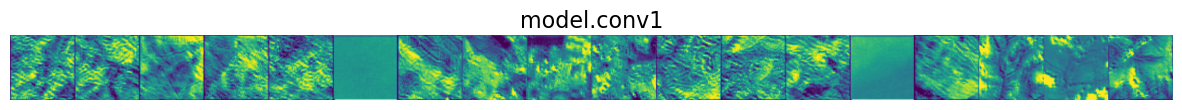

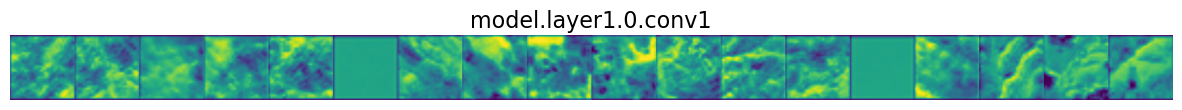

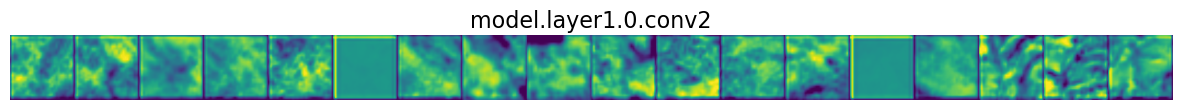

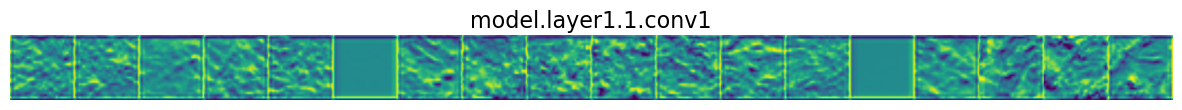

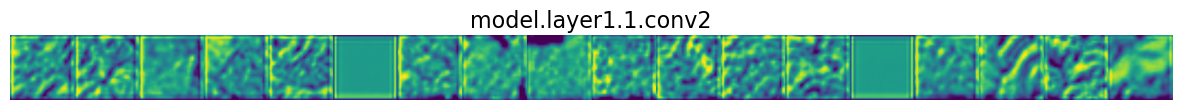

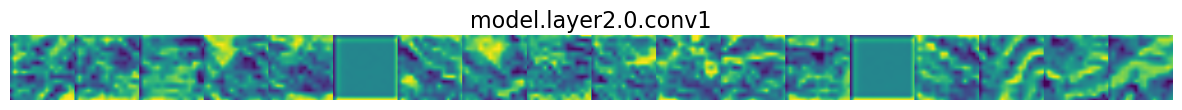

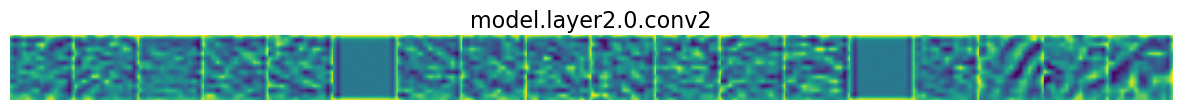

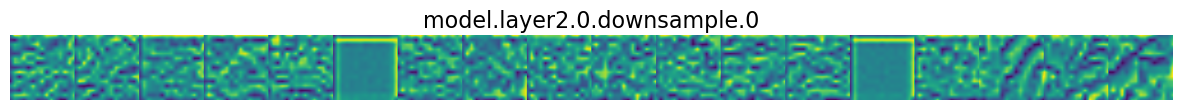

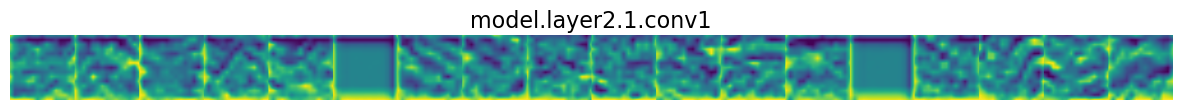

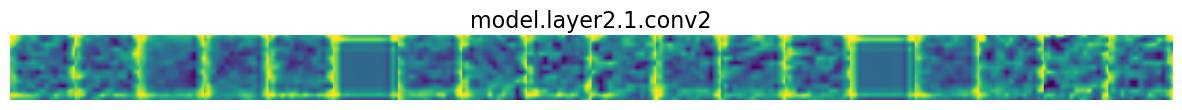

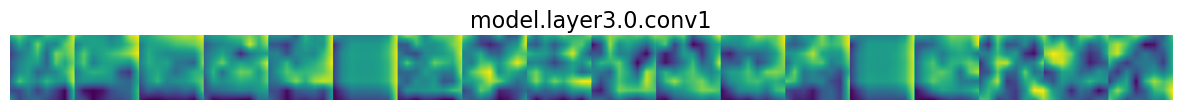

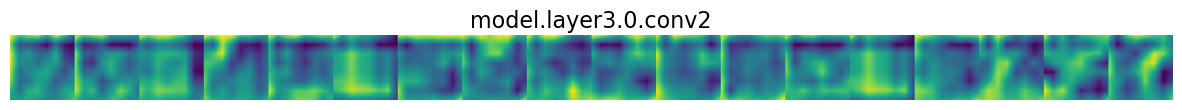

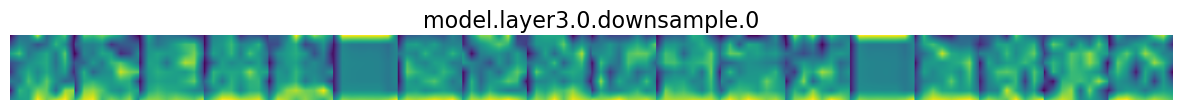

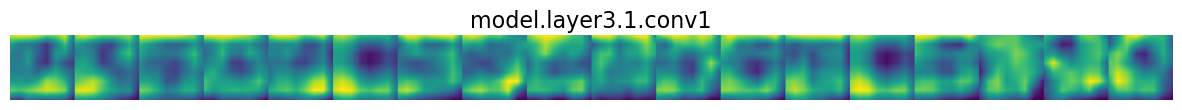

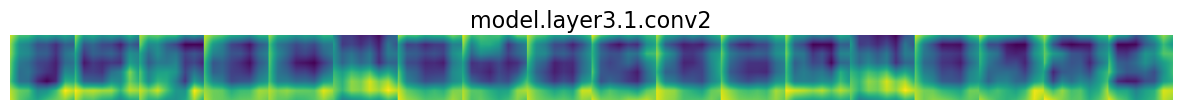

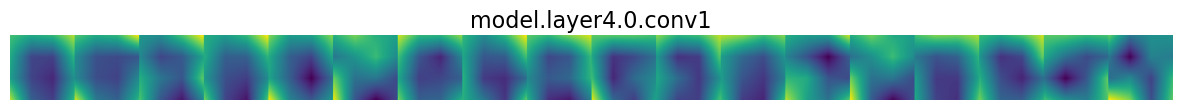

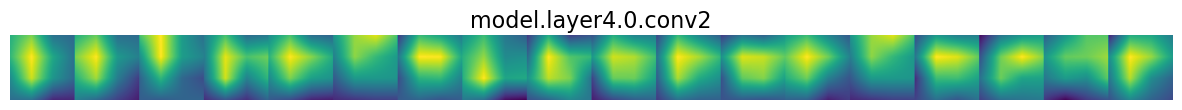

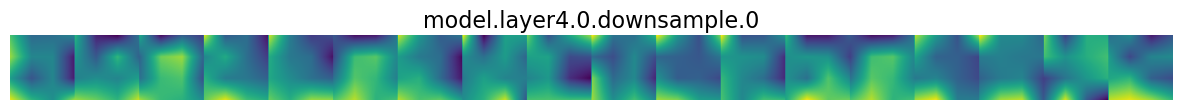

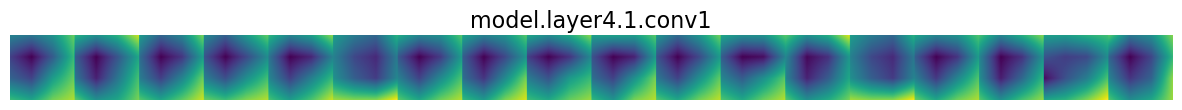

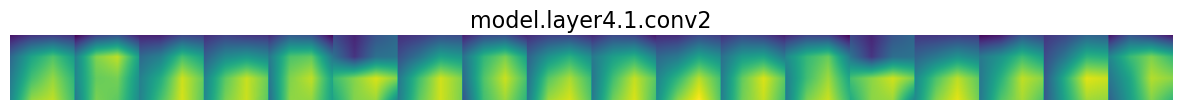

In [105]:
def visualize_activations(layer_names, activations):
    images_per_row = 18  # Adjust for grid layout
    size = 120  # Target size for each feature map (square)

    for layer_name in layer_names:
        layer_activation = activations[layer_name].squeeze().cpu().numpy()
        n_features = layer_activation.shape[0]

        # Calculate the grid dimensions
        n_cols = (n_features + images_per_row - 1) // images_per_row
        display_grid = np.zeros((n_cols * size, images_per_row * size))

        for idx in range(n_features):
            row, col = divmod(idx, images_per_row)
            channel_image = layer_activation[idx]

            # Ensure channel_image is 2D
            if channel_image.ndim == 3:
                channel_image = channel_image[0]  
            elif channel_image.ndim == 4:
                channel_image = channel_image[0, 0]  
            elif channel_image.ndim != 2:
                raise ValueError(f"Unexpected shape for channel image: {channel_image.shape}")

            # Normalize and clip
            channel_image -= channel_image.mean()
            channel_image /= (channel_image.std() + 1e-5)
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            # Resize to target size
            zoom_factors = (
                size / channel_image.shape[0],
                size / channel_image.shape[1],
            )
            channel_image_resized = scipy.ndimage.zoom(
                channel_image, zoom_factors, order=1
            )

            # Add to display grid
            h_start = row * size
            w_start = col * size
            display_grid[
                h_start:h_start + size,
                w_start:w_start + size
            ] = channel_image_resized

        # Plot the grid
        plt.figure(figsize=(15, 15))
        plt.title(layer_name, fontsize=16)
        plt.axis('off')
        plt.imshow(display_grid, cmap='viridis')
        plt.show()

# Call the function
visualize_activations(layer_names, activations)

In [111]:
# Initialize the data module
data_module = BigEarthNetTIFDataModule(bands=bands, dataset_dir=dataset_dir, metadata_csv=metadata_csv)

# Ensure the setup method is called
data_module.setup(stage='test')

checkpoint_path = final_checkpoint.best_model_path
model = BigEarthNetResNet18ModelTIF.load_from_checkpoint(checkpoint_path, class_weights=class_weights, num_classes=DatasetConfig.num_classes, in_channels=12, model_weights=ResNet18_Weights.DEFAULT)
model.eval()
trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    precision='16-mixed'  
)
# Run test
trainer.test(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\isaac\anaconda3\envs\Fyp311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3388690650463104     │
│          test_f1          │    0.25872713327407837    │
│         test_loss         │    1.7236077785491943     │
│      test_precision       │    0.1866496354341507     │
│        test_recall        │    0.6579385995864868     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7236077785491943,
  'test_acc': 0.3388690650463104,
  'test_recall': 0.6579385995864868,
  'test_f1': 0.25872713327407837,
  'test_precision': 0.1866496354341507}]

In [114]:
# Collect predictions and true labels
all_preds = []
all_labels = []

for batch in tqdm(data_module.test_dataloader(), desc="Processing Batches"):
    inputs, labels = batch
    inputs = inputs.to(model.device)
    labels = labels.to(model.device)

    with torch.no_grad():
        logits = model(inputs)  
        preds = torch.sigmoid(logits) > 0.5
        print(f"Sigmoid outputs: {torch.sigmoid(logits)}")  

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

Sigmoid outputs: tensor([[0.1190, 0.7451, 0.4755, 0.7412, 0.7505, 0.7602, 0.8968, 0.9158, 0.2738,
         0.8658, 0.6016, 0.2899, 0.8421, 0.8556, 0.8597, 0.8991, 0.8930, 0.8450,
         0.5342],
        [0.0870, 0.8904, 0.8183, 0.5239, 0.8253, 0.8809, 0.8174, 0.8244, 0.2999,
         0.9078, 0.8972, 0.7190, 0.6663, 0.8371, 0.8524, 0.7690, 0.8502, 0.9136,
         0.5617],
        [0.1292, 0.8120, 0.5805, 0.7064, 0.7767, 0.7877, 0.8456, 0.8837, 0.3054,
         0.9103, 0.7668, 0.4527, 0.7936, 0.8413, 0.8741, 0.8519, 0.8575, 0.8893,
         0.5682],
        [0.1650, 0.8275, 0.4563, 0.7394, 0.7518, 0.7383, 0.8409, 0.9071, 0.3097,
         0.8785, 0.5914, 0.2689, 0.7961, 0.8881, 0.8383, 0.8872, 0.8999, 0.8875,
         0.5088],
        [0.2967, 0.6337, 0.5331, 0.8219, 0.7547, 0.6667, 0.8218, 0.7624, 0.4443,
         0.8064, 0.7207, 0.3892, 0.9074, 0.8796, 0.8046, 0.8501, 0.8801, 0.6792,
         0.8035],
        [0.1851, 0.7951, 0.5701, 0.7625, 0.7333, 0.7679, 0.8292, 0.8546, 0.4223,
  

Sigmoid outputs: tensor([[0.9329, 0.6153, 0.7752, 0.5394, 0.4743, 0.5145, 0.4281, 0.4573, 0.4780,
         0.4122, 0.5168, 0.5112, 0.7318, 0.6972, 0.4601, 0.4219, 0.4725, 0.4567,
         0.4732],
        [0.9324, 0.6175, 0.7752, 0.5406, 0.4766, 0.5143, 0.4295, 0.4550, 0.4790,
         0.4104, 0.5193, 0.5106, 0.7252, 0.6998, 0.4649, 0.4261, 0.4715, 0.4590,
         0.4764],
        [0.2092, 0.7008, 0.6235, 0.8143, 0.8224, 0.7542, 0.8833, 0.7693, 0.2930,
         0.8072, 0.7660, 0.4542, 0.9228, 0.8886, 0.8439, 0.8631, 0.9091, 0.7484,
         0.7989],
        [0.9336, 0.6165, 0.7753, 0.5403, 0.4701, 0.5144, 0.4248, 0.4559, 0.4775,
         0.4092, 0.5130, 0.5074, 0.7295, 0.6993, 0.4576, 0.4204, 0.4731, 0.4527,
         0.4710],
        [0.9319, 0.6175, 0.7751, 0.5404, 0.4758, 0.5141, 0.4302, 0.4554, 0.4795,
         0.4109, 0.5195, 0.5115, 0.7268, 0.6988, 0.4646, 0.4254, 0.4717, 0.4578,
         0.4751],
        [0.9315, 0.6156, 0.7749, 0.5410, 0.4760, 0.5140, 0.4321, 0.4581, 0.4794,
  

Sigmoid outputs: tensor([[0.1859, 0.7340, 0.3388, 0.6560, 0.7141, 0.7169, 0.8763, 0.9380, 0.2935,
         0.8511, 0.5528, 0.2470, 0.7150, 0.7782, 0.8542, 0.8811, 0.8150, 0.8424,
         0.5020],
        [0.2050, 0.6682, 0.4522, 0.8256, 0.7432, 0.7158, 0.8784, 0.8390, 0.3292,
         0.8162, 0.6265, 0.3651, 0.8888, 0.8188, 0.8467, 0.8846, 0.8815, 0.7189,
         0.7377],
        [0.2186, 0.7663, 0.3093, 0.6774, 0.6847, 0.7187, 0.8520, 0.9404, 0.3212,
         0.8637, 0.5440, 0.2358, 0.7129, 0.7904, 0.8380, 0.8756, 0.7962, 0.8596,
         0.5395],
        [0.1567, 0.7954, 0.3875, 0.6641, 0.7463, 0.7335, 0.8398, 0.9162, 0.2589,
         0.8741, 0.5511, 0.2409, 0.7870, 0.8311, 0.8485, 0.8700, 0.8657, 0.8904,
         0.5012],
        [0.2278, 0.7539, 0.3148, 0.6779, 0.7080, 0.7018, 0.8634, 0.9293, 0.3195,
         0.8427, 0.5408, 0.2658, 0.7493, 0.7691, 0.8540, 0.8856, 0.8197, 0.8188,
         0.5145],
        [0.2288, 0.7599, 0.3091, 0.6715, 0.7020, 0.6846, 0.8437, 0.9312, 0.3836,
  

Sigmoid outputs: tensor([[0.9383, 0.6067, 0.7739, 0.5578, 0.4515, 0.5168, 0.4000, 0.4606, 0.4759,
         0.4009, 0.4904, 0.4809, 0.7603, 0.6899, 0.4268, 0.3987, 0.4798, 0.4347,
         0.4514],
        [0.1459, 0.7829, 0.6667, 0.7009, 0.7776, 0.7969, 0.8402, 0.8820, 0.3833,
         0.8769, 0.7365, 0.4267, 0.8742, 0.8773, 0.7984, 0.8372, 0.9045, 0.8862,
         0.6083],
        [0.3612, 0.6513, 0.5933, 0.8498, 0.8011, 0.6677, 0.8071, 0.6874, 0.4526,
         0.8009, 0.7201, 0.4641, 0.9430, 0.8988, 0.8136, 0.8430, 0.9006, 0.6575,
         0.8170],
        [0.2278, 0.6234, 0.5405, 0.8500, 0.7846, 0.7013, 0.8281, 0.7626, 0.4069,
         0.7840, 0.6652, 0.3400, 0.9208, 0.8691, 0.8105, 0.8679, 0.9074, 0.6685,
         0.7588],
        [0.3334, 0.5979, 0.5945, 0.7406, 0.7251, 0.7323, 0.8476, 0.7638, 0.3387,
         0.8181, 0.7075, 0.4570, 0.9004, 0.8716, 0.8007, 0.8922, 0.8672, 0.5902,
         0.7989],
        [0.2770, 0.7182, 0.4876, 0.8775, 0.7739, 0.6432, 0.8421, 0.7830, 0.4472,
  

Sigmoid outputs: tensor([[0.1367, 0.8892, 0.8332, 0.5311, 0.8414, 0.8642, 0.8554, 0.7618, 0.3745,
         0.9061, 0.9428, 0.8387, 0.6434, 0.8640, 0.8925, 0.6661, 0.7461, 0.9033,
         0.6436],
        [0.1505, 0.8104, 0.8320, 0.4884, 0.8145, 0.8882, 0.8413, 0.7232, 0.3155,
         0.9002, 0.8975, 0.8136, 0.6445, 0.8372, 0.8703, 0.7513, 0.7792, 0.8584,
         0.7039],
        [0.1628, 0.8839, 0.8672, 0.4841, 0.8416, 0.8395, 0.8403, 0.7256, 0.4790,
         0.8981, 0.9564, 0.9039, 0.5585, 0.8354, 0.8572, 0.5905, 0.7027, 0.8798,
         0.7026],
        [0.1852, 0.7652, 0.3277, 0.6980, 0.7162, 0.6921, 0.8231, 0.9287, 0.2987,
         0.8852, 0.5664, 0.2412, 0.7759, 0.7958, 0.8440, 0.8591, 0.8389, 0.8612,
         0.4742],
        [0.1511, 0.8691, 0.8618, 0.4135, 0.8456, 0.8924, 0.8944, 0.7181, 0.3374,
         0.9252, 0.9440, 0.9078, 0.5486, 0.8515, 0.8962, 0.6916, 0.7719, 0.8820,
         0.6944],
        [0.1423, 0.7733, 0.6337, 0.6240, 0.7872, 0.7766, 0.8269, 0.8183, 0.3800,
  

Sigmoid outputs: tensor([[0.1680, 0.8058, 0.8525, 0.4496, 0.8692, 0.8849, 0.8828, 0.6917, 0.2834,
         0.9078, 0.9370, 0.9255, 0.5292, 0.8643, 0.9147, 0.7744, 0.7569, 0.8694,
         0.7701],
        [0.1784, 0.8641, 0.8827, 0.4224, 0.8961, 0.8592, 0.8829, 0.6584, 0.3603,
         0.9085, 0.9562, 0.9672, 0.4409, 0.8498, 0.8992, 0.6322, 0.6957, 0.8723,
         0.7771],
        [0.2029, 0.7747, 0.6961, 0.6616, 0.7825, 0.8473, 0.8661, 0.7777, 0.3023,
         0.8689, 0.7444, 0.3994, 0.8934, 0.8462, 0.7999, 0.8279, 0.8977, 0.8389,
         0.7148],
        [0.2016, 0.7596, 0.3651, 0.6293, 0.7159, 0.7429, 0.8646, 0.9366, 0.3224,
         0.8889, 0.6070, 0.2766, 0.7042, 0.8127, 0.8584, 0.8696, 0.8133, 0.8410,
         0.5155],
        [0.1728, 0.7035, 0.4515, 0.5921, 0.7316, 0.7593, 0.8589, 0.9299, 0.2403,
         0.8912, 0.5736, 0.2693, 0.7235, 0.8151, 0.8630, 0.8797, 0.7971, 0.8584,
         0.5140],
        [0.1991, 0.7623, 0.3304, 0.6734, 0.7303, 0.7185, 0.8615, 0.9385, 0.2920,
  

Sigmoid outputs: tensor([[0.9344, 0.6101, 0.7721, 0.5386, 0.4514, 0.5196, 0.4051, 0.4668, 0.4840,
         0.4013, 0.4920, 0.4917, 0.7480, 0.6912, 0.4322, 0.4016, 0.4791, 0.4425,
         0.4525],
        [0.9300, 0.6168, 0.7734, 0.5334, 0.4652, 0.5149, 0.4251, 0.4627, 0.4852,
         0.4080, 0.5123, 0.5074, 0.7293, 0.6956, 0.4561, 0.4182, 0.4698, 0.4531,
         0.4667],
        [0.9288, 0.6190, 0.7729, 0.5380, 0.4734, 0.5128, 0.4315, 0.4573, 0.4828,
         0.4107, 0.5201, 0.5104, 0.7243, 0.6976, 0.4653, 0.4267, 0.4690, 0.4575,
         0.4749],
        [0.7101, 0.7031, 0.8519, 0.6136, 0.6459, 0.6221, 0.6379, 0.4998, 0.6734,
         0.4865, 0.7678, 0.5418, 0.7977, 0.6873, 0.5483, 0.4557, 0.5655, 0.6911,
         0.5604],
        [0.7004, 0.7284, 0.8972, 0.7663, 0.6482, 0.6112, 0.7163, 0.4767, 0.5911,
         0.5047, 0.7731, 0.6930, 0.8572, 0.7957, 0.6876, 0.5318, 0.6912, 0.5996,
         0.6889],
        [0.6278, 0.5623, 0.6880, 0.6907, 0.6348, 0.6677, 0.6983, 0.6424, 0.4581,
  

Sigmoid outputs: tensor([[0.8484, 0.6195, 0.7445, 0.5677, 0.4863, 0.5234, 0.4479, 0.4798, 0.5111,
         0.4779, 0.5892, 0.5733, 0.6971, 0.7266, 0.5521, 0.4848, 0.4716, 0.4637,
         0.5568],
        [0.1537, 0.9097, 0.8935, 0.4038, 0.8793, 0.8749, 0.8800, 0.6779, 0.3360,
         0.9323, 0.9564, 0.9382, 0.5228, 0.8520, 0.9015, 0.6531, 0.7069, 0.8967,
         0.6866],
        [0.1291, 0.8881, 0.8994, 0.3892, 0.8876, 0.8794, 0.8700, 0.6624, 0.3841,
         0.9177, 0.9577, 0.9395, 0.4581, 0.8054, 0.8952, 0.6118, 0.6929, 0.8791,
         0.6461],
        [0.8797, 0.6198, 0.7514, 0.5615, 0.4990, 0.5116, 0.4483, 0.4649, 0.4868,
         0.4508, 0.5674, 0.5528, 0.6878, 0.7188, 0.5398, 0.4741, 0.4566, 0.4815,
         0.5402],
        [0.1433, 0.9046, 0.9378, 0.5645, 0.8635, 0.8778, 0.8668, 0.6835, 0.4601,
         0.8248, 0.9559, 0.9357, 0.6243, 0.7920, 0.8312, 0.6001, 0.6897, 0.8640,
         0.7037],
        [0.9094, 0.6318, 0.7650, 0.5489, 0.4984, 0.5087, 0.4416, 0.4579, 0.4855,
  

Sigmoid outputs: tensor([[0.2068, 0.8595, 0.8872, 0.4574, 0.8877, 0.8483, 0.8654, 0.6773, 0.3902,
         0.8942, 0.9552, 0.9625, 0.4371, 0.8581, 0.8884, 0.5708, 0.6953, 0.8742,
         0.7527],
        [0.1547, 0.9085, 0.9283, 0.4766, 0.8993, 0.8734, 0.8694, 0.6822, 0.3691,
         0.9083, 0.9629, 0.9490, 0.5192, 0.8585, 0.8868, 0.6326, 0.6719, 0.8742,
         0.7536],
        [0.1530, 0.9089, 0.9048, 0.4231, 0.8791, 0.9062, 0.8700, 0.6800, 0.3548,
         0.9100, 0.9576, 0.9424, 0.4827, 0.8461, 0.8702, 0.6299, 0.6918, 0.8869,
         0.6990],
        [0.1511, 0.8517, 0.8722, 0.4080, 0.8755, 0.8732, 0.8713, 0.6811, 0.3376,
         0.9167, 0.9462, 0.9412, 0.4774, 0.8404, 0.8966, 0.6542, 0.7216, 0.8673,
         0.6960],
        [0.1345, 0.8848, 0.8931, 0.4001, 0.8575, 0.9038, 0.8728, 0.6947, 0.2426,
         0.9224, 0.9412, 0.9174, 0.5741, 0.8319, 0.8991, 0.7200, 0.7607, 0.8885,
         0.7040],
        [0.1409, 0.8567, 0.9138, 0.4365, 0.9030, 0.8999, 0.8879, 0.7059, 0.3353,
  

Sigmoid outputs: tensor([[0.1648, 0.7672, 0.6848, 0.8355, 0.8266, 0.7849, 0.8709, 0.7689, 0.4213,
         0.8038, 0.8267, 0.4826, 0.9207, 0.8938, 0.8456, 0.8298, 0.9105, 0.7653,
         0.7733],
        [0.3300, 0.6109, 0.6379, 0.8199, 0.7233, 0.7146, 0.8328, 0.7616, 0.3451,
         0.7890, 0.6617, 0.4092, 0.9274, 0.8989, 0.7844, 0.8678, 0.8882, 0.6463,
         0.7758],
        [0.5937, 0.6384, 0.6478, 0.8420, 0.7538, 0.6074, 0.6766, 0.6390, 0.5340,
         0.6714, 0.6279, 0.4190, 0.9054, 0.8193, 0.7359, 0.6723, 0.8181, 0.6263,
         0.7310],
        [0.5387, 0.6362, 0.6152, 0.7337, 0.6826, 0.6396, 0.7839, 0.6848, 0.5396,
         0.7558, 0.7575, 0.5846, 0.8693, 0.8627, 0.7656, 0.7164, 0.8036, 0.6833,
         0.8398],
        [0.6956, 0.6448, 0.5861, 0.8784, 0.7252, 0.4828, 0.6200, 0.6228, 0.6135,
         0.6653, 0.5523, 0.3852, 0.9178, 0.6841, 0.7248, 0.6311, 0.8229, 0.6661,
         0.5999],
        [0.4082, 0.5983, 0.5475, 0.8259, 0.7716, 0.6376, 0.8051, 0.7284, 0.4181,
  

Sigmoid outputs: tensor([[0.4387, 0.5932, 0.5152, 0.8578, 0.7449, 0.6456, 0.8272, 0.6377, 0.5410,
         0.7544, 0.7219, 0.3637, 0.9022, 0.8765, 0.7756, 0.7664, 0.8873, 0.6440,
         0.8168],
        [0.7057, 0.5804, 0.6993, 0.7079, 0.6493, 0.5961, 0.6451, 0.5611, 0.5138,
         0.6068, 0.6227, 0.4737, 0.8674, 0.7760, 0.6644, 0.6412, 0.7078, 0.5585,
         0.7191],
        [0.6746, 0.5619, 0.6352, 0.6535, 0.6140, 0.5985, 0.6781, 0.6245, 0.5208,
         0.7011, 0.6679, 0.6023, 0.8599, 0.8107, 0.6872, 0.6748, 0.7101, 0.5527,
         0.7570],
        [0.6553, 0.5462, 0.6445, 0.6945, 0.6208, 0.6208, 0.7119, 0.6122, 0.4749,
         0.6673, 0.6316, 0.5128, 0.8705, 0.8107, 0.6951, 0.7009, 0.7086, 0.5452,
         0.7539],
        [0.5367, 0.6560, 0.7053, 0.8080, 0.7486, 0.7123, 0.8308, 0.6495, 0.5014,
         0.7278, 0.7458, 0.5004, 0.8825, 0.8971, 0.7676, 0.7551, 0.8652, 0.6258,
         0.8538],
        [0.4868, 0.5631, 0.6608, 0.7837, 0.7216, 0.6829, 0.8180, 0.6953, 0.3776,
  

Sigmoid outputs: tensor([[0.1516, 0.8898, 0.9095, 0.3738, 0.9125, 0.9021, 0.8717, 0.6857, 0.2734,
         0.9378, 0.9540, 0.9605, 0.5157, 0.8312, 0.9048, 0.7382, 0.7806, 0.8828,
         0.6899],
        [0.1277, 0.9087, 0.8819, 0.4980, 0.8900, 0.8947, 0.8476, 0.6795, 0.3345,
         0.9056, 0.9491, 0.9360, 0.5955, 0.8778, 0.8948, 0.7130, 0.7276, 0.9081,
         0.7388],
        [0.1492, 0.8989, 0.8944, 0.3613, 0.9058, 0.9145, 0.8491, 0.7059, 0.2446,
         0.9285, 0.9439, 0.9520, 0.5694, 0.8512, 0.8930, 0.7786, 0.7968, 0.8978,
         0.7355],
        [0.1413, 0.8901, 0.8890, 0.4266, 0.8891, 0.9166, 0.8502, 0.7131, 0.2489,
         0.9185, 0.9290, 0.9178, 0.6623, 0.8465, 0.8737, 0.8124, 0.8193, 0.8844,
         0.7696],
        [0.1260, 0.9082, 0.8778, 0.4370, 0.9073, 0.9115, 0.8710, 0.7399, 0.2411,
         0.9385, 0.9514, 0.9261, 0.6099, 0.8488, 0.9095, 0.7924, 0.7977, 0.9141,
         0.7010],
        [0.1656, 0.8856, 0.8743, 0.3558, 0.8855, 0.9137, 0.8687, 0.7033, 0.2012,
  

Sigmoid outputs: tensor([[0.1818, 0.8731, 0.8680, 0.5629, 0.8843, 0.8896, 0.8688, 0.6675, 0.3209,
         0.8725, 0.9348, 0.9264, 0.6043, 0.8486, 0.8801, 0.7319, 0.7877, 0.8813,
         0.7775],
        [0.2438, 0.9203, 0.9091, 0.4859, 0.9051, 0.8774, 0.8523, 0.6996, 0.4149,
         0.8951, 0.9672, 0.9738, 0.5134, 0.8756, 0.8823, 0.5802, 0.7187, 0.9148,
         0.8627],
        [0.1140, 0.8624, 0.8901, 0.4725, 0.8625, 0.8503, 0.8167, 0.7266, 0.3270,
         0.8761, 0.9348, 0.9253, 0.5099, 0.8370, 0.8688, 0.6297, 0.6142, 0.8656,
         0.7407],
        [0.2129, 0.8924, 0.8939, 0.5878, 0.8508, 0.8796, 0.8111, 0.7050, 0.3936,
         0.8324, 0.9282, 0.9250, 0.6984, 0.8713, 0.8403, 0.6698, 0.7439, 0.8779,
         0.8084],
        [0.9344, 0.6116, 0.7730, 0.5359, 0.4585, 0.5205, 0.4135, 0.4631, 0.4826,
         0.4010, 0.4989, 0.4942, 0.7355, 0.6958, 0.4395, 0.4088, 0.4783, 0.4428,
         0.4582],
        [0.3276, 0.8157, 0.8085, 0.6703, 0.8296, 0.7884, 0.7994, 0.6427, 0.4833,
  

Sigmoid outputs: tensor([[0.2407, 0.9080, 0.8945, 0.4269, 0.8838, 0.8530, 0.8372, 0.6650, 0.3832,
         0.8798, 0.9489, 0.9674, 0.5460, 0.8765, 0.8664, 0.5944, 0.6303, 0.8994,
         0.8414],
        [0.1681, 0.8867, 0.8840, 0.5060, 0.8881, 0.8995, 0.8582, 0.6774, 0.2965,
         0.9034, 0.9494, 0.9546, 0.5299, 0.8547, 0.8973, 0.6905, 0.7698, 0.8942,
         0.8107],
        [0.1592, 0.9321, 0.9071, 0.4398, 0.8949, 0.8875, 0.8585, 0.6912, 0.3673,
         0.8965, 0.9634, 0.9628, 0.4552, 0.8603, 0.8847, 0.5883, 0.6644, 0.9089,
         0.7703],
        [0.2695, 0.8056, 0.8694, 0.6002, 0.8510, 0.8852, 0.8731, 0.6978, 0.2963,
         0.8694, 0.8970, 0.8999, 0.7775, 0.8951, 0.8694, 0.8413, 0.8316, 0.8491,
         0.8986],
        [0.2232, 0.8979, 0.9019, 0.4648, 0.8880, 0.8606, 0.8398, 0.6886, 0.3807,
         0.8808, 0.9488, 0.9697, 0.5230, 0.8616, 0.8679, 0.6107, 0.6632, 0.8864,
         0.8281],
        [0.2046, 0.9143, 0.9152, 0.4892, 0.8891, 0.8951, 0.8505, 0.6840, 0.3638,
  

Sigmoid outputs: tensor([[0.1014, 0.8940, 0.8314, 0.6394, 0.8485, 0.8865, 0.8324, 0.8185, 0.3415,
         0.8809, 0.9083, 0.6854, 0.8470, 0.8656, 0.8600, 0.7720, 0.8586, 0.9026,
         0.7455],
        [0.0943, 0.8504, 0.8555, 0.5721, 0.8487, 0.9181, 0.8334, 0.7738, 0.2243,
         0.9016, 0.8844, 0.7408, 0.7456, 0.8291, 0.8584, 0.8460, 0.8535, 0.8900,
         0.7350],
        [0.1044, 0.8517, 0.7246, 0.8133, 0.8761, 0.8288, 0.9010, 0.7912, 0.2948,
         0.8215, 0.8291, 0.5544, 0.8801, 0.9009, 0.8559, 0.8540, 0.9205, 0.8729,
         0.7240],
        [0.1735, 0.8951, 0.8268, 0.6087, 0.8458, 0.8943, 0.8496, 0.7408, 0.3689,
         0.8562, 0.8928, 0.7487, 0.7698, 0.9052, 0.8093, 0.7617, 0.8589, 0.8848,
         0.7465],
        [0.2055, 0.6307, 0.6152, 0.7535, 0.8226, 0.7329, 0.8805, 0.7995, 0.2506,
         0.8459, 0.7457, 0.4319, 0.9035, 0.8980, 0.8482, 0.9189, 0.8917, 0.7123,
         0.8154],
        [0.1178, 0.9144, 0.8965, 0.4256, 0.8920, 0.9206, 0.8169, 0.7474, 0.1960,
  

Sigmoid outputs: tensor([[0.6874, 0.6060, 0.5177, 0.9314, 0.7045, 0.6037, 0.7843, 0.5171, 0.5253,
         0.6680, 0.5822, 0.3102, 0.9047, 0.8698, 0.7311, 0.7730, 0.8993, 0.4770,
         0.6658],
        [0.4731, 0.7736, 0.5201, 0.8993, 0.7357, 0.5967, 0.7337, 0.5198, 0.4675,
         0.6528, 0.6051, 0.4201, 0.9258, 0.7639, 0.7278, 0.7004, 0.8821, 0.5468,
         0.6747],
        [0.3484, 0.8437, 0.5217, 0.9048, 0.7120, 0.7128, 0.8295, 0.5523, 0.4230,
         0.6388, 0.5528, 0.3967, 0.9267, 0.7856, 0.7182, 0.7560, 0.9313, 0.6287,
         0.4601],
        [0.2538, 0.7624, 0.4892, 0.9034, 0.7852, 0.7536, 0.9011, 0.5765, 0.3727,
         0.5772, 0.4838, 0.4003, 0.9248, 0.8644, 0.6904, 0.8554, 0.9285, 0.5344,
         0.5048],
        [0.2584, 0.7943, 0.4748, 0.9071, 0.7172, 0.7424, 0.8501, 0.6462, 0.5618,
         0.6656, 0.5745, 0.4235, 0.9233, 0.7708, 0.7478, 0.7542, 0.9207, 0.6560,
         0.4909],
        [0.4112, 0.8058, 0.5051, 0.9361, 0.7687, 0.6348, 0.7944, 0.5573, 0.4322,
  

Sigmoid outputs: tensor([[0.2456, 0.7205, 0.6910, 0.8351, 0.8264, 0.7636, 0.8498, 0.7705, 0.3952,
         0.7454, 0.7951, 0.5166, 0.9127, 0.9211, 0.8698, 0.8575, 0.9094, 0.7374,
         0.8276],
        [0.6022, 0.7364, 0.7083, 0.8069, 0.7055, 0.6777, 0.6595, 0.5704, 0.6193,
         0.6735, 0.8379, 0.6572, 0.8533, 0.7992, 0.7365, 0.5207, 0.7511, 0.6501,
         0.6541],
        [0.2189, 0.7358, 0.7491, 0.7616, 0.8564, 0.8278, 0.9074, 0.6743, 0.2483,
         0.7911, 0.8107, 0.6681, 0.8758, 0.8934, 0.8305, 0.8471, 0.8687, 0.7514,
         0.8769],
        [0.1378, 0.8669, 0.8832, 0.5437, 0.8310, 0.8930, 0.8305, 0.7076, 0.2909,
         0.8658, 0.9087, 0.8680, 0.7095, 0.8578, 0.8572, 0.7487, 0.7891, 0.8583,
         0.7405],
        [0.1756, 0.8919, 0.8506, 0.5478, 0.8526, 0.8883, 0.7879, 0.7613, 0.3492,
         0.8609, 0.9293, 0.8990, 0.6576, 0.8732, 0.8579, 0.6949, 0.7521, 0.9109,
         0.7991],
        [0.2524, 0.9169, 0.8709, 0.5672, 0.8807, 0.8633, 0.7797, 0.6968, 0.4376,
  

Sigmoid outputs: tensor([[0.2271, 0.8031, 0.8490, 0.7282, 0.8431, 0.8689, 0.8690, 0.6206, 0.3524,
         0.7876, 0.8784, 0.8602, 0.8826, 0.8763, 0.8055, 0.7867, 0.8505, 0.7898,
         0.8963],
        [0.4754, 0.6646, 0.7176, 0.8077, 0.7545, 0.7489, 0.8817, 0.6098, 0.4286,
         0.6968, 0.7921, 0.6325, 0.8749, 0.9094, 0.8071, 0.7761, 0.8399, 0.6053,
         0.9155],
        [0.4060, 0.7492, 0.7126, 0.8232, 0.8281, 0.8505, 0.8695, 0.5828, 0.3289,
         0.6444, 0.8057, 0.7087, 0.8447, 0.9294, 0.8549, 0.7636, 0.8065, 0.7104,
         0.9320],
        [0.1693, 0.8728, 0.8750, 0.5026, 0.8618, 0.8803, 0.8093, 0.7079, 0.2666,
         0.8792, 0.9241, 0.9142, 0.6667, 0.8463, 0.8633, 0.7326, 0.7801, 0.8964,
         0.8028],
        [0.1926, 0.8906, 0.8955, 0.5010, 0.8830, 0.8924, 0.8785, 0.7163, 0.2745,
         0.9009, 0.9425, 0.9632, 0.6569, 0.8695, 0.8680, 0.7284, 0.7889, 0.8925,
         0.8277],
        [0.2422, 0.8817, 0.8544, 0.4414, 0.8804, 0.8862, 0.8599, 0.6673, 0.3060,
  

Sigmoid outputs: tensor([[0.3035, 0.8475, 0.8399, 0.7078, 0.8285, 0.8621, 0.8666, 0.6774, 0.3727,
         0.7782, 0.9021, 0.8648, 0.7807, 0.9199, 0.8472, 0.7455, 0.7914, 0.8616,
         0.9127],
        [0.3325, 0.7571, 0.7810, 0.7500, 0.8401, 0.8435, 0.8755, 0.6094, 0.2785,
         0.7773, 0.8045, 0.7482, 0.8704, 0.9213, 0.8371, 0.8433, 0.8449, 0.7187,
         0.9139],
        [0.2822, 0.7524, 0.8146, 0.6682, 0.8307, 0.8422, 0.8815, 0.6417, 0.3098,
         0.8057, 0.8463, 0.8141, 0.8657, 0.9187, 0.7972, 0.8527, 0.8382, 0.6931,
         0.8814],
        [0.2411, 0.8804, 0.8698, 0.4422, 0.8676, 0.8858, 0.8528, 0.6877, 0.3404,
         0.8902, 0.9349, 0.9468, 0.6236, 0.8667, 0.8634, 0.7075, 0.7433, 0.8935,
         0.8336],
        [0.2961, 0.8709, 0.8094, 0.5833, 0.8721, 0.8911, 0.8653, 0.7062, 0.3043,
         0.8406, 0.8900, 0.8796, 0.7350, 0.9256, 0.8503, 0.8098, 0.7864, 0.8650,
         0.8992],
        [0.9325, 0.6119, 0.7725, 0.5329, 0.4592, 0.5202, 0.4169, 0.4651, 0.4861,
  

Processing Batches: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]

Sigmoid outputs: tensor([[0.3341, 0.6430, 0.7865, 0.7502, 0.8308, 0.8051, 0.8639, 0.6768, 0.3211,
         0.8257, 0.7883, 0.7851, 0.9197, 0.9148, 0.8089, 0.8815, 0.8487, 0.6208,
         0.9019],
        [0.4052, 0.6531, 0.7476, 0.8663, 0.8277, 0.7593, 0.9076, 0.6486, 0.4158,
         0.6992, 0.8166, 0.6054, 0.9084, 0.9376, 0.8545, 0.8516, 0.8878, 0.6552,
         0.9129],
        [0.3834, 0.7037, 0.7868, 0.7367, 0.8124, 0.8016, 0.8731, 0.6314, 0.3726,
         0.7829, 0.8435, 0.7588, 0.8787, 0.9210, 0.8239, 0.8355, 0.8375, 0.6361,
         0.9016],
        [0.3161, 0.8399, 0.8192, 0.7020, 0.8303, 0.7938, 0.8317, 0.5951, 0.4617,
         0.7769, 0.8844, 0.8644, 0.7775, 0.8814, 0.8163, 0.6356, 0.7257, 0.8276,
         0.8930],
        [0.6396, 0.6318, 0.7244, 0.7418, 0.7506, 0.6839, 0.8204, 0.6107, 0.4228,
         0.7479, 0.7608, 0.6519, 0.8729, 0.8978, 0.7529, 0.7694, 0.7750, 0.5909,
         0.8674],
        [0.3895, 0.6353, 0.7735, 0.7866, 0.8250, 0.8008, 0.8882, 0.6662, 0.3786,
  